In [ ]:
!pwd
import os
#os._exit(00)

/content/Mask_RCNN


In [1]:
!pwd

/content


In [ ]:
import os
os.chdir('/content/Mask_RCNN')
!python3 setup.py install

In [6]:
os.chdir('../')
!pwd

/content


In [14]:
import os
import shutil
import sys
import urllib

import skimage.io
import numpy as np
# Root directory of the project
from Mask_RCNN.mrcnn.visualize import random_colors

ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "coco/"))  # To find local version
from coco import coco
import cv2


In [19]:


# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

colors = random_colors(len(class_names))
class_dict = {
    name: color for name, color in zip(class_names, colors)
}


COCO_MODEL_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


def download_trained_weights(coco_model_path, verbose=1):
    if verbose > 0:
        print("Downloading pretrained model to " + coco_model_path + " ...")
    with urllib.request.urlopen(COCO_MODEL_URL) as resp, open(coco_model_path, 'wb') as out:
        shutil.copyfileobj(resp, out)
    if verbose > 0:
        print("... done downloading pretrained model!")


def load_model():
    # Directory to save logs and trained model
    MODEL_DIR = os.path.join("logs")
    # Local path to trained weights file
    COCO_MODEL_PATH = os.path.join("mask_rcnn_coco.h5")

    if not os.path.exists(COCO_MODEL_PATH):
        download_trained_weights(COCO_MODEL_PATH)

    config = InferenceConfig()
    config.display()
    # Create model object in inference mode.
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    return model


def predict_static_image(model):
    file_name = 'test.jpg'
    image = skimage.io.imread(file_name)
    # Run detection
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                                class_names, r['scores'])



def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):

    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        color = class_dict[label]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


def predict_live_stream(model):
    # No GRAY SCALING in mask-RCNN
    cap = cv2.VideoCapture(0)

    while True:
        print("ONGOING")
        _, image = cap.read()
        image = cv2.resize(image, (512, 512))
        results = model.detect([image], verbose=1)
        r = results[0]

        masked_image = display_instances(image, r['rois'], r['masks'], r['class_ids'],
                                         class_names, r['scores'])
        cv2.imshow("masked_image", masked_image)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            break



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

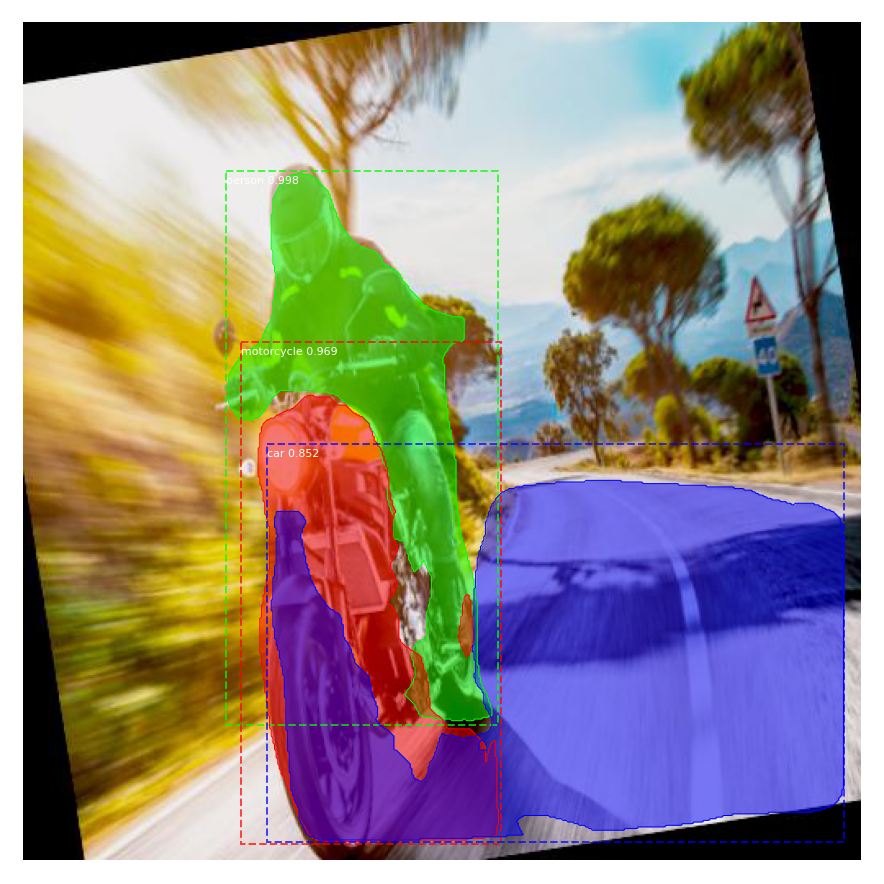

In [20]:
model = load_model()
predict_static_image(model)